In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
import string
import json
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from sci_analysis import analyze
from scipy.stats import ttest_ind

# 1 - First steps to clean the dataset:

The CMU dataset contains very different types of movies, from 10-minute 1920s clip to modern Marvel movies.

We chose to focus on **feature films**, and thus to analyze only movies that last for more than one hour. The term feature film originally referred to the main, full-length film in a cinema program that included a short film and often a newsreel [Wikipedia](https://en.wikipedia.org/wiki/Feature_film).

We will perform those two first steps :
- Remove movies for which we don't have the title
- Select only full-length feature (movies of more than one hour long)

In [2]:
character_metadata = pd.read_csv('Data/character.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_release_date',
                                                                              'Character_name',
                                                                              'Actor_date_of_birth',
                                                                              'Actor_gender',
                                                                              'Actor_height',
                                                                              'Actor_ethnicity',
                                                                              'Actor_name',
                                                                              'Actor_age_at_movie_release',
                                                                              'Freebase_character/actor_map_ID',
                                                                              'Freebase_character_ID',
                                                                              'Freebase_actor_ID'])

movie_metadata = pd.read_csv('Data/movie.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_name',
                                                                              'Movie_release_date',
                                                                              'Movie_box_office_revenue',
                                                                              'Movie_runtime',
                                                                              'Movie_languages',
                                                                              'Movie_countries',
                                                                              'Movie_genres'])

plot_summaries = pd.read_csv('Data/plot_summaries.txt', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'summary'])

In [3]:
#Copy of movie_metadata dataset
movie_metadata_readable = movie_metadata.copy(deep= True)

# Make the column Movie_languages, Movie_countries and Movie_genres more readable (i.e change as list)

def readable(column):
    pd.set_option('mode.chained_assignment', None) #remove warning
    for i in column.index:
        d=json.loads(column[i]) #change set of each row from the colomn to dict
        column[i]=list(d.values()) #change the dict into list

readable(movie_metadata_readable['Movie_languages'])
readable(movie_metadata_readable['Movie_countries'])
readable(movie_metadata_readable['Movie_genres'])

movie_metadata_readable.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [4]:
#Filtering of movie_metada, keeping only full-length features movies (more than 60 minutes long) and that have a Title in the database.
movie_metadata_filtered = movie_metadata_readable.copy(deep=True)
print(f"Number of movies in the database before the first cleaning step: {movie_metadata_filtered['Movie_release_date'].size}.")


movie_metadata_filtered.dropna(subset=['Movie_name'],inplace=True)

movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_runtime >= 60]


#Cleaning of the Movie_release_date column, to keep only the year of release
movie_metadata_filtered.dropna(subset=['Movie_release_date'], inplace = True)
movie_metadata_filtered["Movie_release_date"] = movie_metadata_filtered['Movie_release_date'].apply(lambda x : str(x)[:4]).apply(lambda x : int(x))


print(f"Number of movies in the database after this first cleaning step: {movie_metadata_filtered['Movie_release_date'].size}.")

Number of movies in the database before the first cleaning step: 81741.
Number of movies in the database after this first cleaning step: 52286.


## 1.1 - Language filtering
We aim to filter the dataset to keep movies with English title. In fact, the NLP packages are mostly developed for English language. To do this easily we only select movies that have English as main language (as they should also have an English title).

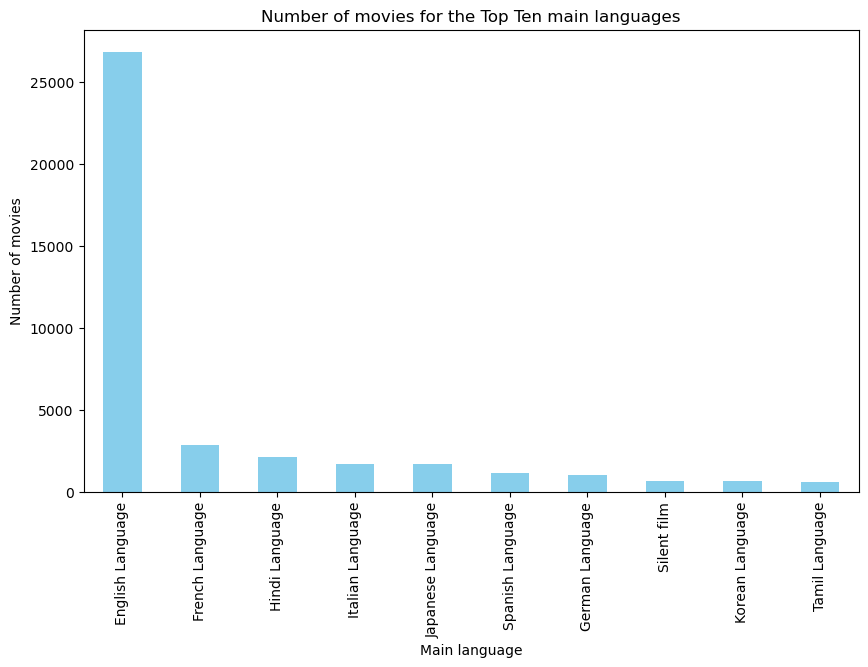

In [5]:
#Movie distribution per languages: top ten main languages

movie_metadata_filtered['Movie_main_language'] = movie_metadata_filtered.Movie_languages.str[0]
movie_metadata_filtered['Movie_main_language'] = movie_metadata_filtered.Movie_main_language.astype('category')

# Create a DataFrame with feature counts
main_languages = movie_metadata_filtered['Movie_main_language'].value_counts()

# Select the top ten features
top_ten_main_languages = main_languages.head(10)

# Plot the bar plot
plt.figure(figsize=(10, 6))
top_ten_main_languages.plot(kind='bar', color='skyblue')
plt.title('Number of movies for the Top Ten main languages')
plt.xlabel('Main language')
plt.ylabel('Number of movies')
plt.show()



In [6]:
#Create dataset with filtered language:  english as first language
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_main_language=="English Language"] #English Language as First Language

print(f"Number of movies in the database after the language filtering: {movie_metadata_filtered['Movie_release_date'].size}.")

Number of movies in the database after the language filtering: 26855.


After the removal of the shortest movies and of movies without title, 52'286 movies remain. 51.3%  of them (26'855) are in English. 
Thus, keeping only the movies in English does not reduce too much the size of the whole database.

## 1.2 - Temporal distribution

Let's explore our data. One first thing to look at is the temporal distribution of movies.

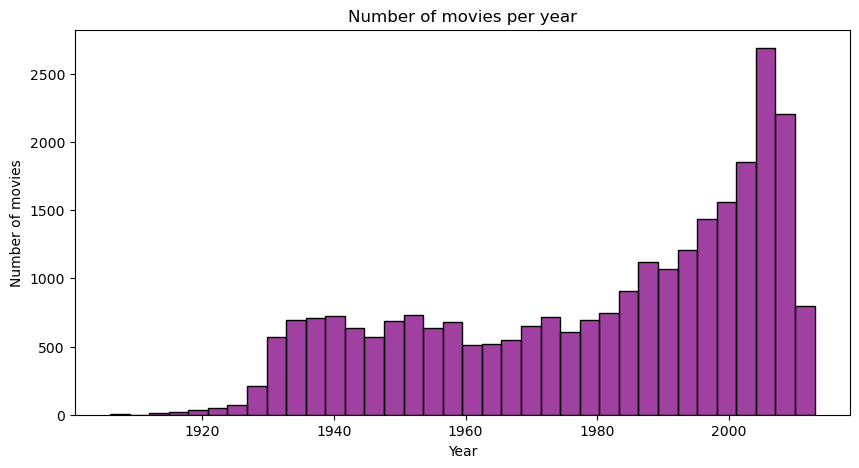

In [7]:
#Number of movies per year
plt.figure(figsize=(10,5))
ax = sns.histplot(movie_metadata_filtered,x='Movie_release_date',stat='count',color="purple").set(title="Number of movies per year",xlabel="Year",ylabel="Number of movies")

Our dataset was extracted in 2012. As a result, many movies released after 2012 are missing. Let's see how many movies have a release date after 2012.

In [8]:
movie_metadata_filtered[movie_metadata_filtered.Movie_release_date > 2012]

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_main_language
2942,29097142,/m/0dlk_qn,Movie 43,2013,NaN,175.0,[English Language],[United States of America],[Comedy],English Language
4676,34957039,/m/0j7mv7h,Postman Pat: The Movie — You Know You're The One,2013,NaN,117.0,[English Language],[United Kingdom],"[Family Film, Animation]",English Language
9447,3081811,/m/08q3xy,Sin City 2,2013,NaN,120.0,[English Language],[United States of America],"[Thriller, Crime Fiction, Superhero movie, Act...",English Language
13338,36120997,/m/0k0wrfg,Ned Venture,2013,NaN,90.0,[English Language],[United States of America],[Comedy film],English Language
14160,31106576,/m/0gh8bt9,Bullet to the Head,2013,NaN,97.0,[English Language],[United States of America],"[Thriller, Crime Fiction, Action]",English Language
16772,23468311,/m/06w6vd9,"Quick, Slip Me A Bride",2013,NaN,100.0,[English Language],[United Kingdom],[Romance Film],English Language
18210,34682342,/m/0j3d8n7,Calvary,2013,NaN,147.0,[English Language],"[Ireland, United Kingdom]","[Black comedy, Comedy film, Drama]",English Language
32241,34779274,/m/0j3f7xf,Viy. Returning,2013,NaN,112.0,"[English Language, Russian Language]","[Ukraine, Czech Republic, Russia]","[Thriller, Mystery, Horror, Adventure]",English Language
32338,35229863,/m/0j7m_4k,McConkey,2013,NaN,90.0,[English Language],[United States of America],"[Biographical film, Documentary]",English Language
32529,35720024,/m/0jt1g0l,Teen Beach Musical,2013,NaN,125.0,[English Language],[United States of America],"[Musical, Family Film]",English Language


We remove these movies released after 2012 to be consistent with the extraction date of the CMU database.

In [9]:
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_release_date <= 2012]

print(f"Number of movies in the database after the language filtering: {movie_metadata_filtered['Movie_release_date'].size}.")

Number of movies in the database after the language filtering: 26840.


## 1.3 - Genre processing

For our sentimental analysis using NLP, we may need to use movies genres as categories. We thus need to assign every movie in only one genre category (preferably the main genre, which is the first in the list). We thus created a more **"basic" dictionnary of genres** and assigned most categories to one of these "main/major" genres.

In [10]:
# For some of the categories we had to look for it and to look at the movies that had this genre to know it which categories we should put it in.

# 1st step: create a new genre dictionnary
dict_genre = {
    "Action": ["Action/adventure", "ninja movie", "epic", "auto racing", "martial arts film","Combat Films", "race movie", "samurai cinema", "Super hero", "superhero movie", "superhero","Outlaw biker film"],
    "Adventure": ["Adventure", "travel"],
    "Art": ["Art film","Concert film", "Film-Opera", "Operetta", "Punk rock", "Rockumentary", "Space opera", "Singing cowboy", "Hip hop movies", "Breakdance", "Dance", "musical", "& Literature", "Literature", "Music","Experimental film"],
    "Comedy": ["Humour", "Tragicomedy", "Ealing Comedies", "Comedy film","Comedy", "Adventure Comedy", "Comedy of manners", "Workplace comedy", "comedy-drama", "Buddy Picture", "Buddy cop", "Parody","Black comedy","Satire","Screwball comedy","Musical comedy","Buddy film","Mockumentary"], 
    "Documentary": ["Docudrama", "Historical Documentaries", "Rockumentary", "media studies", "media satire", "Political Documentary"],
    "Drama": ["Melodrama", "Tragedy", "Tragicomedy", "Docudrama", "Family drama", "Comedy-drama", 'illnesses & disabilities','Costume drama',"Political drama","Exploitation"], 
    "Political":[ "Political cinema","LGBT","Blaxploitation","Christian film","Culture & Society","Religious Film"], 
    "Family": ["Computer Animation","Coming of age","Family Film", "Animation", "Animated cartoon", "Children's film", "children's", "children's entertainment", "children's fantasy", "children's/family", "For children","Christmas movie","Television movie","Teen"], 
    "Fiction": ["Science Fiction","fairy tail", "fictional film", "medical fiction", "mythological fantasy", "sci fi pictures", 'sci fi pictures original films', "sword and sorcery films", "sword and sandal", "time travel", "supernatural", "Alien invasion","Alien Film", "Zombie film", "Z-movie", "z movie", "Zombie","Fantasy","Disaster","Fan film"],
    "Historical": ["Short Film","Historical fiction","Period piece","history", "Biographical", "British History", "British Empire Film", "British new wave", "Historical Epic", "Cold War", "Historical Documentaries", "Biography", "Biopic [feature]", "The Netherlands in World War II", "Gulf War", "movies about gladiators","Biographical film","Historical drama","Sponsored film"],
    "Horror": ["Natural Horror film", "Sci-fi Horror", "road-horror", "Creature Movie", "Monster Movie", "Creature","Slasher"],
    "Old movie":['Black-and-white',"Silent film"],
    "Porn": ["Pornographic movie", "Pornography", "Softcore Porn", "Adult", "Sexploitation", "Erotica", "homoeroticism", "erotic thriller", "Hardcore pornography", "Homoeroticism","Gay pornography"], 
    "Romance": ["Romance film", "romantic fantasy","Romantic comedy","Romantic drama","Pre-code"],
    "Sport": ["baseball", "boxing", "sports"],
    "Thriller": [ "film à clef", "mystery", "suspense", 'crime', 'crime fiction', 'crime thriller', "master criminal films", "detective", "Master Criminal Films", "Heist", "Gangster Film","Film noir","Psychological thriller","Detective fiction","Spy"],
    "Western": ["Singing cowboy", "Westerns", "B-Western", "Epic Western", "Spaghetti Western"],
    "World cinema": ["Northern","Chinese Movies", "Japanese Movies", "Latino", "americana", "bengali cinema", "filipino movies", "Anime", "Indie"],
    "War film": ["war", "War effort", "anti-war", "anti-war film", "nuclear warfare", "foreign legion"],
}

In [11]:
# 2nd step: Revert the current dictionnary, because it is easier to manipulate

dict_genre_revert = {}
for key, value in dict_genre.items():
    key = key.lower()
    for v in value:
        v = v.lower()
        dict_genre_revert[v] = key
    dict_genre_revert[key] = key

In [12]:
# Drop movie without genre (=emplty list in 'Movie_genres')
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered['Movie_genres'].map(lambda d: len(d)) > 0]

In [13]:
# 3rd step: Give main genre to each movie 

Main_genres=[]
for i in movie_metadata_filtered.index:
    N=len(movie_metadata_filtered['Movie_genres'][i])
    k=0
    while k < N:
        genre = movie_metadata_filtered['Movie_genres'][i][k].lower()
        if genre in dict_genre_revert.keys():
            genre=dict_genre_revert.get(genre)
            Main_genres.append(str(genre))
            k=N+1
        else:
            k+=1

movie_metadata_filtered['Movie_main_genre']=Main_genres


[Text(0.5, 0, 'Main genres'),
 Text(0, 0.5, 'Number of movies'),
 Text(0.5, 1.0, 'Number of movies per genre')]

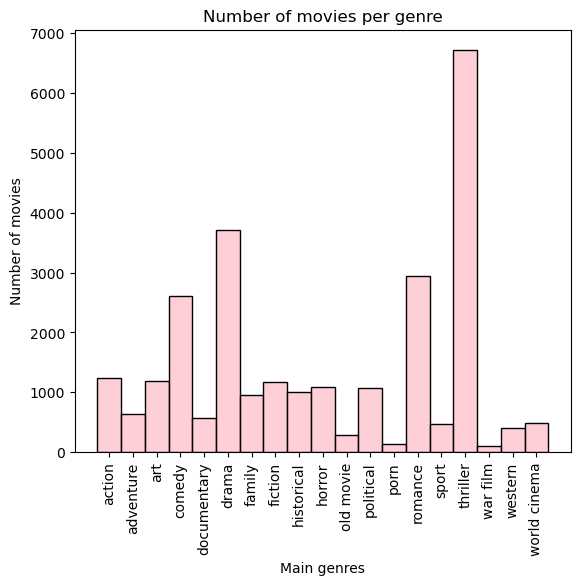

In [14]:
movie_metadata_filtered['Movie_main_genre'] = movie_metadata_filtered.Movie_main_genre.astype('category')

ax = sns.histplot(movie_metadata_filtered,x='Movie_main_genre',stat='count',color='pink')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.gcf().subplots_adjust(bottom=0)
ax.set(xlabel="Main genres",ylabel="Number of movies",title="Number of movies per genre")

 We can see that most of the movies fall in the 'Thriller', 'Drama', 'Romance' and 'Comedy' categories. 

We won't be using the 'Movie_genres', 'Movie_languages', and 'Movie_main_language' for further analyses, we thus drop these columns.

In [15]:
movie_metadata_filtered.drop(labels=["Movie_genres","Movie_languages","Movie_main_language"],axis=1,inplace=True)

## 1.4 - Processing character metadata 

We want to merge the character dataset and the movie dataset on the "Wikipedia_movie_ID". It will be useful to investigate the relationship between the characters and the title of the movie (Batman in Batman movies for example). We thus compute a column with a list of characters for each movie.

In [16]:
#Drop row without character names
movie_characters = movie_metadata_filtered.copy(deep=True)

character_metadata_copy = character_metadata.copy(deep=True)
character_metadata_copy.dropna(subset=['Character_name'], inplace=True)

character_metadata_copy.drop(labels=["Movie_release_date","Freebase_movie_ID"],axis=1,inplace=True)

movie_characters=movie_characters.merge(character_metadata_copy, how='inner',left_on='Wikipedia_movie_ID', right_on='Wikipedia_movie_ID')

movie_characters = movie_characters[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_box_office_revenue', 'Movie_runtime', 'Movie_countries', 'Movie_main_genre', 'Character_name', 'Freebase_character_ID']]


movie_characters = movie_characters.groupby('Wikipedia_movie_ID').agg({
    'Movie_name': 'first',  
    'Movie_box_office_revenue': 'first', 
    'Movie_runtime': 'first',  
    'Movie_countries': 'first',  
    'Movie_main_genre': 'first',  
    'Character_name': lambda x: list(x),  
    'Freebase_character_ID':  lambda x: list(x)
}).reset_index()
movie_characters.sample(5).head()

,Wikipedia_movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Freebase_character_ID
14388,25011263,The Hook,NaN,98.0,[United States of America],drama,[P.J. Briscoe],[/m/0h2wr69]
6936,5469422,The Poof Point,NaN,90.0,[United States of America],fiction,[Eddie Ballard],[/m/0h2th69]
15616,29730492,Wuthering Heights,NaN,123.0,[United Kingdom],romance,"[Mrs Linton, Heathcliff, Heathcliff, Mr Earnsh...","[/m/0h0j6hj, /m/02pyc3p, /m/02pyc3p, /m/0h0j8h..."
14354,24870003,Cracks,NaN,104.0,"[Spain, Ireland, United Kingdom]",political,"[Laurel, Miss G, Di, Fiamma, Poppy, Lily, Rosi...","[/m/0bgjpl2, /m/0bgjpf6, /m/0bgjpds, /m/0bgjpd..."
11469,15530875,Big Time,NaN,87.0,[United States of America],drama,"[Eddie Burns, Lily Clark, Gloria, Sybil, Eli]","[/m/0jvlwm9, /m/0jvlwmx, /m/0jvlwmm, /m/0jvlwn..."


What is the proportion of movies with a title that contain one of the character's name?

In [17]:
# Check if one of the character's name is present in the movie title
def is_in_title(df):
    characters = df['Character_name']
    title = str(df['Movie_name'])
    for i in characters:
        if str(i) in title:
            return True
        return False

movie_characters['Protagonist_in_title'] = movie_characters.apply(lambda x: is_in_title(x), axis=1)
movie_with_protagonist_in_title = movie_characters['Protagonist_in_title'].sum()

print(f"Fraction of movie titles containing character name: {movie_with_protagonist_in_title / len(movie_characters):.2%}")
print(movie_characters.loc[movie_characters['Protagonist_in_title'] == 1, ['Movie_name', 'Character_name']])

Fraction of movie titles containing character name: 2.94%
                               Movie_name  \
3                                  Batman   
6                          Batman Forever   
43                         The Terminator   
52                               THX 1138   
81                 The Life of Emile Zola   
...                                   ...   
16270           The Elizabeth Smart Story   
16380               Margaret Bourke-White   
16410  Captain America II: Death Too Soon   
16430                      Up Goes Maisie   
16463     Rita Hayworth: The Love Goddess   

                                          Character_name  
3      [Batman, Catwoman, Joker, Penguin, Riddler, Al...  
6      [Batman, Harvey Dent, Dr. Chase Meridian, Suga...  
43     [Terminator, Kyle Reese, Sarah Connor, Punk Le...  
52     [THX, SEN, SRT, LUH, PTO, TWA, NCH, DWY, IMM, ...  
81                                          [Emile Zola]  
...                                            

Does this parameter have an impact on the success? 

*Naive analysis, to be continued...*

We now merge our filtered movie dataset with the movie_character data created on the "Wikipedia_movie_ID" column. We only keep "Character_name", "Character in title" and "Wikipedia_movie_ID" on the movie_character dataset.

In [18]:
movie_characters.drop(labels=["Movie_name","Movie_box_office_revenue","Movie_runtime","Movie_countries","Movie_main_genre","Freebase_character_ID"],axis=1,inplace=True)

movie_metadata_filtered = movie_metadata_filtered.merge(movie_characters,how='left', on = 'Wikipedia_movie_ID')
movie_metadata_filtered.to_csv("Data/movies_preprocessed.csv")

**We now have a clean dataset that contains only the information we need for our further analysis.**

# 2 - First visualizations : insights on the evolution of title features

## ADD CODE w evolutions of title length in character / sentiment analysis / part-of-speech analysis

inspi from data story website

In [19]:
# Deep copy of the pre-processed CMU dataset
movies = movie_metadata_filtered.copy(deep=True)

In [ ]:
# Helper functions to count the words and characters in movie titles
def count_words(x):
    # remove eventual spaces at the beginning and at the end of the string, split the string, count the words
    return len(x.strip().split())

def count_characters(input_string):
    return len(input_string)

movies['Title_length'] = movies['Movie_name'].apply(count_words)
movies['Title_length_characters'] = movies['Movie_name'].apply(count_characters)

# 3 - Analysis of success confounders

The IMdB movies dataset imported from IMdB website is huge (882.4 Mo) and therefore long to process. As it contains many unuseful features and many unuseful movies (i.e. not present in the CMU pre-processed dataset), we will reduce its size and combine it to the IMdB ratings dataset (23.7 Mo) and then merge the obtained dataset to the pre-processed CMU dataset. In the end, we will get a pre-processed CMU-IMdB dataset that is simpler and faster to use.

**The pre-processing is described in the notebook 'Dataset-preprocessing-IMdB-Rotten-tomatoes'.**

## 3.1 - Financial data pre-processing

We are interested in conducting an analysis to explore the relationship between the title of a movie and its success. While the title seems to be a crucial aspect since it is a the first hook, it is undoubtable that other factors, such as the cast, director, and movie studio, may exert a more significant influence on a film's success. To gain a comprehensive understanding of the impact of the title, it is essential to **analyze potential confounding variables affecting success**. 
 
 In this context, success is measured by both the **movie revenue** (box office earnings minus budget) and the **ratings** from IMDb. To do so, an indicator of success is calculated.

Any data including budget and revenues has to be adjusted with inflation rates. To do this, Consumer Price Indexes were found on OECD statistics, for the years comprised between 1913 and 2012.

We chose to consider the cmu_imdb dataset because the movies_ratings dataset (with IMdB + Rottent tomatoes ratings) provides fewer data.

In [26]:
# Load the pre-processed CMU-IMdB dataset and drop rows with a NaN box office revenue
movies_cmu_imdb = pd.read_csv('Data/cmu_imdb.csv')
print('Size of the dataset with all box office revenues : ', movies_cmu_imdb.shape)

movies_cmu_imdb.dropna(subset=['Movie_box_office_revenue'], inplace=True)
print('Size of the dataset without null box office revenues : ', movies_cmu_imdb.shape)
movies_cmu_imdb.head(2)

Size of the dataset with all box office revenues :  (13825, 15)
Size of the dataset without null box office revenues :  (3142, 15)


,Unnamed: 0.1,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Character_in_title,Audience_imdb_rating,Audience_imdb_count,Title_length
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,"['Akooshay', 'Lieutenant Melanie Ballard', 'De...",False,4.9,56887,3
1,1,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,['Roger Grant AKA Alexander'],False,6.8,2268,3


Droping the rows without Box office revenue truly decreases the dataset size. This will have to be taken in account for further studies.

Now we have to adjust the box office revenue with the inflation rate, which we can due thanks to the consumer price index (CPI), using 2012 as a year of reference.

In [27]:
# Load the dataframe with Consumer Price indexes (CPI)
# The year of reference is 2012 (latest movie release year)
# Adjust each movie box office with the consumer price index corresponding to the year of release 

cpi = pd.read_csv('Data/CPI.csv', sep=';')
cpi['Annual'] = cpi['Annual'].str.replace(',', '.')
cpi['Annual'] = pd.to_numeric(cpi['Annual'], errors='coerce')

cpi_value_2012 = cpi.loc[cpi['Year'] == 2012, 'Annual'].values[0] # take 2012 as the reference year for the cpi 

def adjust_inflation_box_office(row):
    year = row['Movie_release_date']
    consumer_price_index = cpi['Annual'][cpi['Year'] == year].values[0]
    revenue_adjusted = row['Movie_box_office_revenue'] * (cpi_value_2012 / consumer_price_index)
    return revenue_adjusted

# Adjust the box office with the inflation by adding a new column Box_office_adjusted
movies_cmu_imdb['Box_office_adjusted'] = movies_cmu_imdb.apply(adjust_inflation_box_office, axis=1)
movies_cmu_imdb.head(2)


,Unnamed: 0.1,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Character_in_title,Audience_imdb_rating,Audience_imdb_count,Title_length,Box_office_adjusted
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,"['Akooshay', 'Lieutenant Melanie Ballard', 'De...",False,4.9,56887,3,1.816424e+07
1,1,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,['Roger Grant AKA Alexander'],False,6.8,2268,3,5.862128e+07


Complementary data about movies was found on https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/.
We indeed need more information on production companies and movie budget for the success analysis. 
Information about movie directors was also found on IMdB.
All those additional data is comprised in the dataset movies_additional_info. The budget also has to be adjusted because of the inflation.

In [28]:
movies_additional_info = pd.read_csv('Data/movies_additional_info.csv')
movies_additional_info.shape

(41293, 6)

In [29]:
# Keep only movies budgets for years comprised between 1913 and 2012 (because of the inflation CPI dataset) 

movies_additional_info = movies_additional_info[(movies_additional_info['ReleaseYear'] >= 1913) & (movies_additional_info['ReleaseYear'] < 2013)]
movies_additional_info['ReleaseYear'] = movies_additional_info['ReleaseYear'].astype('int64')

# Adjust movies budgets with inflation with each consumer price index of the year of release 

def adjust_inflation_budget(row):
    year = row['ReleaseYear']
    consumer_price_index = cpi['Annual'][cpi['Year'] == year].values[0]
    revenue_adjusted = row['Budget'] * (cpi_value_2012 / consumer_price_index)
    return revenue_adjusted

movies_additional_info['Budget_adjusted'] = movies_additional_info.apply(adjust_inflation_budget, axis=1)

movies_additional_info.shape

(34035, 7)

The additional information about movies dataset is merged with clean the dataset we used previously, movies_cmu_imdb.

In [30]:
# Merge movies_budget_ratings with movies_cmu_imdb on Movie Name and Movie Release Date

success_data = movies_cmu_imdb.merge(movies_additional_info, left_on=['Movie_name', 'Movie_release_date'], right_on=['Title', 'ReleaseYear'], how='inner')
print('Size of the dataset with IMdB ratings and budget : ',success_data.shape)

Size of the dataset with IMdB ratings and budget :  (2655, 23)


We first thought to compile the profit (revenue-budget). Let's see if we have enough data:

In [31]:
#Number of movies without budget data
success_data[success_data['Budget_adjusted']==0].shape

(1310, 23)

This reduce our dataframe a lot. We thus decide to work only with the revenue (?)

In [32]:
# To remove?
# Adding the movie profit column, with Profit = Box office revenue - Budget 

success_data['Profit'] = success_data['Box_office_adjusted'] - success_data['Budget_adjusted']
Unuseful = ['Title', 'ReleaseYear']
success_data.drop(Unuseful, axis=1, inplace=True)
success_data.head(2)

,Unnamed: 0.1,Unnamed: 0_x,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,...,Audience_imdb_rating,Audience_imdb_count,Title_length,Box_office_adjusted,Unnamed: 0_y,Budget,Production Companies,Director,Budget_adjusted,Profit
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,...,4.9,56887,3,1.816424e+07,4330,28000000,"['Screen Gems', 'Storm King Productions', 'Ani...",John Carpenter,3.630040e+07,-1.813615e+07
1,1,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,...,6.8,2268,3,5.862128e+07,7660,2000000,['Twentieth Century Fox Film Corporation'],Henry King,3.256738e+07,2.605390e+07


In [33]:
# Normalise the movies profits and the ratings to have homogenised and comparatible success indicators

success_data['Movie_box_office_revenue'].dropna(inplace = True)
print('Size of the dataset with the budget and ratings : ', success_data.shape)

success_data['Profit_standardized']= ((success_data['Profit']-success_data['Profit'].mean())/ success_data['Profit'].std())
success_data['imdb_rating_standardized']= (success_data['Audience_imdb_rating']-success_data['Audience_imdb_rating'].mean())/ success_data['Audience_imdb_rating'].std()
success_data['Revenue_standardized']= (success_data['Movie_box_office_revenue']-success_data['Movie_box_office_revenue'].mean())/ success_data['Movie_box_office_revenue'].std()

# Create an indicator for success, based on ratings and box office revenues
success_data["Success_indicator"]= (success_data['imdb_rating_standardized'] + success_data['Revenue_standardized'])/2
success_data.head(2)


Size of the dataset with the budget and ratings :  (2655, 22)


,Unnamed: 0.1,Unnamed: 0_x,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,...,Unnamed: 0_y,Budget,Production Companies,Director,Budget_adjusted,Profit,Profit_standardized,imdb_rating_standardized,Revenu_standardized,Success_indicator
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,...,4330,28000000,"['Screen Gems', 'Storm King Productions', 'Ani...",John Carpenter,3.630040e+07,-1.813615e+07,-0.604779,-1.455197,-0.324095,-0.889646
1,1,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,...,7660,2000000,['Twentieth Century Fox Film Corporation'],Henry King,3.256738e+07,2.605390e+07,-0.208255,0.544569,-0.448579,0.047995


[Text(0.5, 0, 'Success indicator'),
 Text(0, 0.5, 'Number of movies'),
 Text(0.5, 1.0, 'Distribution of our success indicator among movies of the dataset')]

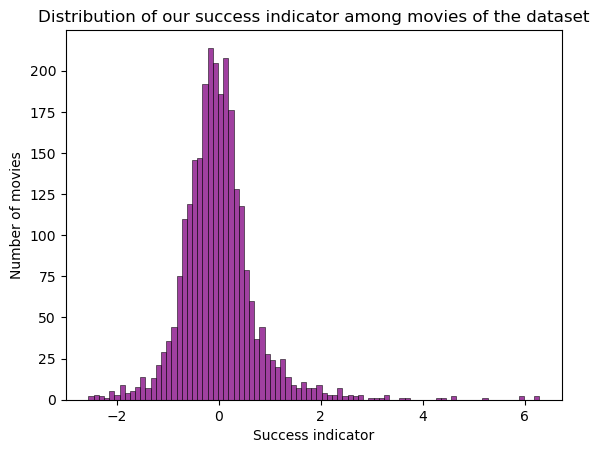

In [34]:
ax=sns.histplot(data=success_data,x='Success_indicator',color="purple")
ax.set(xlabel='Success indicator',ylabel='Number of movies',title='Distribution of our success indicator among movies of the dataset')

## 3.2 - Famous actors influence

We would like to know if the presence of famous actors influence the movie success. To do so, we use a list of the 100 most famous actors (taken from IMdB) to discriminate famous and not famous actors.

In [35]:
# load the dataset with the list of famous actors (top 100 from IMdB) and filter only the useful columns 

famous_actors= pd.read_csv('Data/famous_actors.csv')

top100actors=famous_actors.head(100)
unuseful = ['Description', 'Birth Date', 'Created', 'Modified', 'Known For', 'Position']
top100actors.drop(unuseful, axis =1, inplace=True)
top100actors.head(2)

,Const,Name
0,nm0000134,Robert De Niro
1,nm0000197,Jack Nicholson


In [36]:
# Merge movies and character metadata to have access to actors information for each movie, on Wipikedia_movie_ID
success_data=success_data.merge(character_metadata[['Wikipedia_movie_ID','Actor_name','Freebase_character_ID']], on='Wikipedia_movie_ID', how='inner')

In [37]:
# Group movies and actors dataframe by movie and aggregate actors and characters
success_data = success_data.groupby('Wikipedia_movie_ID').agg({
    'Freebase_movie_ID': 'first', 'Movie_name': 'first',
    'Movie_release_date': 'first', 'Movie_box_office_revenue': 'first', 'Movie_runtime': 'first',
    'Movie_countries': 'first', 'Movie_main_genre':'first', 'Box_office_adjusted':'first','Director':'first',
    'Audience_imdb_rating': 'first', 'Audience_imdb_count': 'first', 'Budget': 'first', 'Protagonist_in_title':'first',
    'Profit': 'first', 'Budget_adjusted': 'first', 'Production Companies':'first','Revenue_standardized':'first',
    'Profit_standardized': 'first', 'imdb_rating_standardized': 'first', 'Success_indicator': 'first',
    'Actor_name': lambda x: ','.join(x.dropna()),
    'Freebase_character_ID': lambda x: ', '.join(x.dropna())
}).reset_index()
print('Size of the dataset with the actors: ', success_data.shape)


Size of the dataset with the actors:  (2630, 23)


In [38]:
#We  change the type of object of the actors name (from str to list of str)

success_data['Actor_name']=success_data['Actor_name'].apply(lambda x: x.split(sep=','))


In [39]:
# To be considered as famous, an actor has to be in the famous_actors dataset
# We create a column to indicate for each movie how many famous actors he has.

Famous_Actors=[]
for i in success_data.index:
    A=0
    for actor in success_data['Actor_name'][i]:
        if actor in list(top100actors['Name']):
            A+=1
    Famous_Actors.append(A)


success_data['Famous_actors_count']=Famous_Actors


/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/1430237009.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=success_data, x='Famous_actors_count',y='Success_indicator',palette='colorblind')


[Text(0.5, 0, 'Number of famous actors'),
 Text(0, 0.5, 'Success indicator'),
 Text(0.5, 1.0, 'Average success of movies depending of the number of famous actors')]

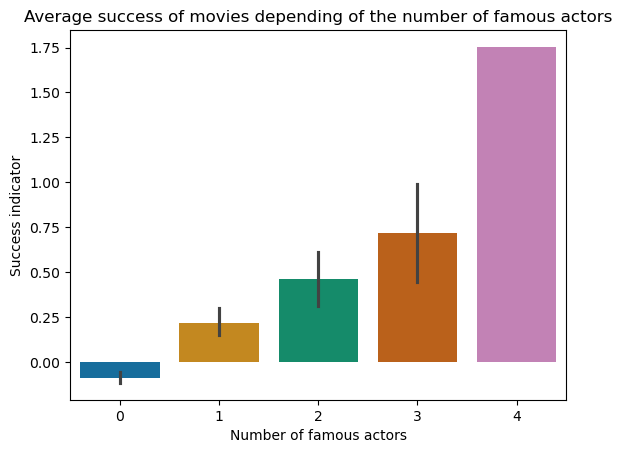

In [40]:
# Create a bar plot to visualize the relationship between the presence of famous actors  and the success indicator of movies

ax = sns.barplot(data=success_data, x='Famous_actors_count',y='Success_indicator',palette='colorblind')
ax.set(xlabel='Number of famous actors',ylabel='Success indicator',title='Average success of movies depending of the number of famous actors')

Here we are studying the influence of the cast on a movie's success, specifically exploring whether the number of renowned actors correlates with heightened success in a film. Our findings suggest a positive association between the presence of famous actors and increased movie success. This observation is interesting as renowned actors may serve as confounding variables, potentially impacting the relationship between our movie title and its success.

To confirm our hypothesis, let's perform statistical test. Here, we want to know if  the success indicator mean of one of at least the groups (no famous actor, 1 famous actor, 2 famous actors, 3 famous actor or 4 famous actors) is different.
To do so, we perform a ANOVA 1 test or its non-parametrical equivalent, a Kruskal-Wallis test.

Only one movie has 4 famous actors, we thus decide to remove this group from our anaylysis to be able to perform the statistical test.

In [66]:
# Drop row with 4 famous actor for analysis
Famous_actor_influence=success_data.copy(deep=True)
Famous_actor_influence=Famous_actor_influence[Famous_actor_influence['Famous_actors_count'] != 4]

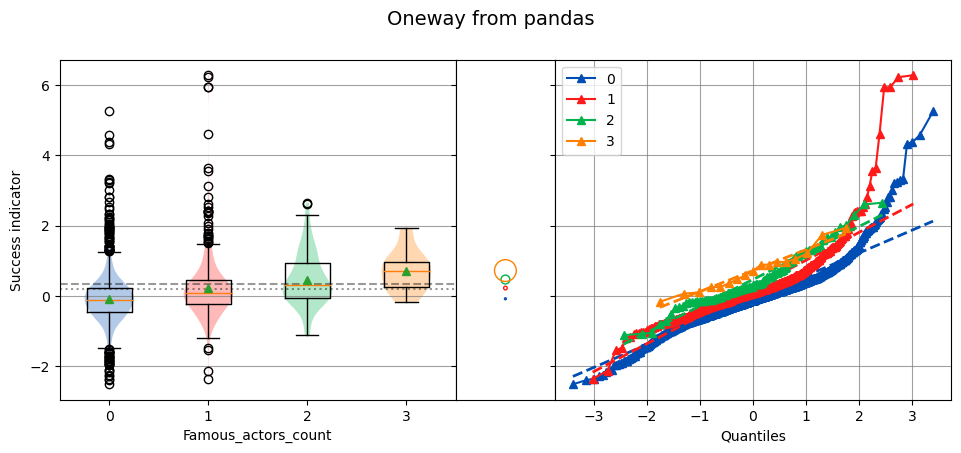



Overall Statistics
------------------

Number of Groups =  4
Total            =  2629
Grand Mean       =  0.3293
Pooled Std Dev   =  0.7323
Grand Median     =  0.1976


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1975          -0.0856        0.6810       -2.5227       -0.1141        5.2549       0             
544            0.2204        0.8936       -2.3667        0.0921        6.2895       1             
93             0.4634        0.7623       -1.1219        0.3031        2.6540       2             
17             0.7191        0.5759       -0.1699        0.6992        1.9365       3             


Levene Test
-----------

alpha   =  0.0500
W value =  3.4351
p value =  0.0163

HA: Variances are not equal



Kruskal-Wallis
--------------

alpha   =  0.0500
h value =  128.9765
p value =  0.0000


In [67]:
# Perform the statistical test: the function analyze chooses automatically the parametric or 
#non-parametric test depending on the normality of the residual and the homoscedasticity of the data
analyze(
    Famous_actor_influence['Success_indicator'],
    groups=Famous_actor_influence['Famous_actors_count'],
    categories='Famous_actors_count',
    name='Success indicator',
    title='Oneway from pandas'
)

print()

The p-value of the Kruskal-Wallis test is inferiror 0.05. We can reject the negative hypothesis H0 (all means are the same). The success indicator means of movies is thus different for the number of famous actors in the movie.

To conclude, it will be important to consider this confounding factor for future studies. Our upcoming investigations will extend beyond to explore additional factors, including the movie production studio, the director influence, and the budget.

## TO REFORMULATE?

## 3.3 - Famous production studios influence   

We would like to know whether the fact that a movie was producted by a famous studio influences the success of a movie. The influence of a famous studio on the success of a movie is a multifaceted topic that involves various aspects of the film industry : brand recognition, financial backing, marketing, promotion, distribution and industrial networks...

A list of famous movie studios was found on  (https://en.wikipedia.org/wiki/Major_film_studios#:~:text=Today%2C%20the%20Big%20Five%20majors,to%20afford%20to%20watch%20films) : 
NBCUniversal, Paramount Pictures Corporation, Warner Bros Entertainment, Walt Disney Studios, Sony Pictures, RKO Pictures, United Artists, Metro-Goldwyn-Mayer, 20th Century Fox. Those studios are indeed considered as the best studios today and also as the best ones over the last century. 

In [42]:
#top_studios = ['NBCUniversal', 'Paramount Pictures Corporation', 'Warner Bros Entertainment', 'Walt Disney Productions', 'Sony Pictures', 'RKO Pictures', 'United Artists', 'Metro-Goldwyn-Mayer', 'Twentieth Century Fox Film Corporation']
top_studios_keywords = ['NBC', 'Universal', 'Paramount', 'Warner', 'Disney', 'Sony', 'RKO', 'United Artists', 'Goldwyn', 'Century Fox']

In [43]:
# Analyse if movies were produced by a famous studio
# A studio is famous if its name is related to the top studios 
success_data['IsFamousStudio']= success_data['Production Companies'].apply(lambda x: any(keyword in x for keyword in top_studios_keywords))
success_data.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Box_office_adjusted,Director,...,Budget_adjusted,Production Companies,Revenu_standardized,Profit_standardized,imdb_rating_standardized,Success_indicator,Actor_name,Freebase_character_ID,Famous_actors_count,IsFamousStudio
0,3217,/m/014hr,Army of Darkness,1992,21502796.0,81.0,['United States of America'],horror,3.518918e+07,Sam Raimi,...,1.800143e+07,"['Universal Pictures', 'Renaissance Pictures',...",-0.234513,-0.287812,1.176074,0.470781,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...","/m/0hgcnkq, /m/089hc6, /m/06_krl, /m/0jtgxg3, ...",0,True
1,3947,/m/0191n,Blue Velvet,1986,8551228.0,120.0,['United States of America'],thriller,1.791389e+07,David Lynch,...,1.256934e+07,['De Laurentiis Entertainment Group (DEG)'],-0.389376,-0.394083,1.491826,0.551225,"[Dick Green, Isabella Rossellini, Kyle MacLach...","/m/0hgw_bt, /m/0gz5lsj, /m/0h39qn5, /m/0hgw_dk...",0,False
2,4231,/m/01cbx,Buffy the Vampire Slayer,1992,16624456.0,86.0,['United States of America'],action,2.720581e+07,Fran Rubel Kuzui,...,1.145545e+07,"['Twentieth Century Fox Film Corporation', 'Ku...",-0.292844,-0.300710,-0.613190,-0.453017,"[Kristy Swanson, Donald Sutherland, Paul Reube...","/m/0b41h, /m/0h5s5mz, /m/0h5s5p6, /m/0h2n0pr, ...",0,True
3,4728,/m/01hq1,Batman Returns,1992,266822354.0,126.0,"['United States of America', 'United Kingdom']",thriller,4.366530e+08,Tim Burton,...,1.309195e+08,"['PolyGram Filmed Entertainment', 'Warner Bros.']",2.698799,2.301351,0.860321,1.779560,"[Cristi Conaway, Michael Gough, Pat Hingle, Ja...","/m/0h5rr59, /m/02r129, /m/031v20, /m/0h5rr4q, ...",1,True
4,5224,/m/01lsl,Citizen Kane,1941,1585634.0,119.0,['United States of America'],thriller,2.476609e+07,Orson Welles,...,1.311574e+07,"['RKO Radio Pictures', 'Mercury Productions']",-0.472665,-0.337500,2.123331,0.825333,"[Dorothy Comingore, Erskine Sanford, Everett S...","/m/04vwr27, /m/04vwr0s, /m/04vwr2j, /m/04vwq_x...",0,True


/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/1874491527.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=success_data, x='IsFamousStudio',y='Success_indicator',palette='colorblind')
/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/1874491527.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['Non famous studio','Famous studio'],xlabel=None, ylabel='Success indicator',title='Average success of movies depending of the fame of the studio')


[[Text(0, 0, 'Non famous studio'), Text(1, 0, 'Famous studio')],
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Success indicator'),
 Text(0.5, 1.0, 'Average success of movies depending of the fame of the studio')]

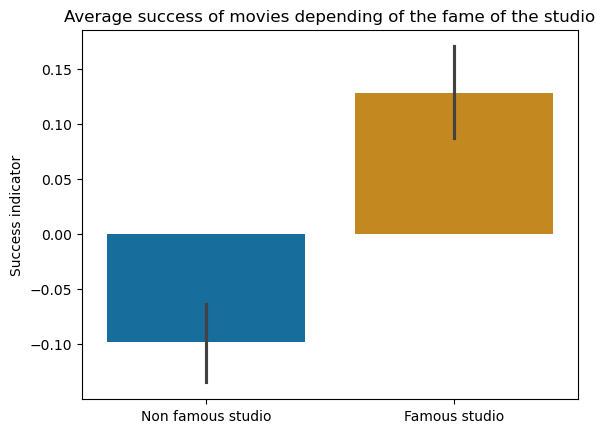

In [44]:
# Create a bar plot to visualize the relationship between the fame of the studio (IsFamousStudio=1) and the success indicator of movies

success_data['IsFamousStudio'] = success_data['IsFamousStudio'].astype(int)
ax = sns.barplot(data=success_data, x='IsFamousStudio',y='Success_indicator',palette='colorblind')
ax.set(xticklabels=['Non famous studio','Famous studio'],xlabel=None, ylabel='Success indicator',title='Average success of movies depending of the fame of the studio')

The means of success indicator for the 2 groups seems different. Let's perfom a T-test to confirm this hypothetis

In [70]:
# T-test
cat1 = success_data[success_data['IsFamousStudio']==0]
cat2 = success_data[success_data['IsFamousStudio']==1]

ttest_ind(cat1['Success_indicator'],cat2['Success_indicator'])

TtestResult(statistic=-7.771743602725118, pvalue=1.1019508649349882e-14, df=2628.0)

The p-value of the t-test is inferior to 0.05. We can thus reject H0 (means of the two groups are the same). We can thus conclude that the fame of the studio has an impact on the success. If the studio is one of the most famous studio, it is more likely to have a high success indicator.

Again, this conclusion is important for our future study on success related to title, because the production studio is a confounder for success.

## 3.4 - Famous Directors influence

Exploring the impact of renowned film directors on movie success : this analysis aims to uncover insights into how distinguished directors contribute to the success of the films they helm. 
We select a list of the top 50 influential directors (found on https://thecinemaarchives.com/2020/08/17/the-250-best-directors-of-all-time/) and analyse the influence on the success of the movies helmed by those directors. 

In [46]:
famous_directors = pd.read_csv('Data/FilmDirectors.csv')
famous_directors.rename(columns={'Directors;': 'Directors'}, inplace =True)
famous_directors['Directors'] = famous_directors['Directors'].str.extract(r'\d+\.\s(.+);')
top50directors = famous_directors.head(50)
top50directors.head(3)

,Directors
0,Alfred Hitchcock
1,Stanley Kubrick
2,Ingmar Bergman


In [47]:
success_data['IsFamousDirector']= success_data['Director'].isin(top50directors['Directors'])

/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/1590611859.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=success_data, x='IsFamousDirector',y='Success_indicator',palette='colorblind')
/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/1590611859.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['Non famous directors','Famous directors'],xlabel=None,ylabel='Success indicator',title='Average success of movies depending of the fame of the director')


[[Text(0, 0, 'Non famous directors'), Text(1, 0, 'Famous directors')],
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Success indicator'),
 Text(0.5, 1.0, 'Average success of movies depending of the fame of the director')]

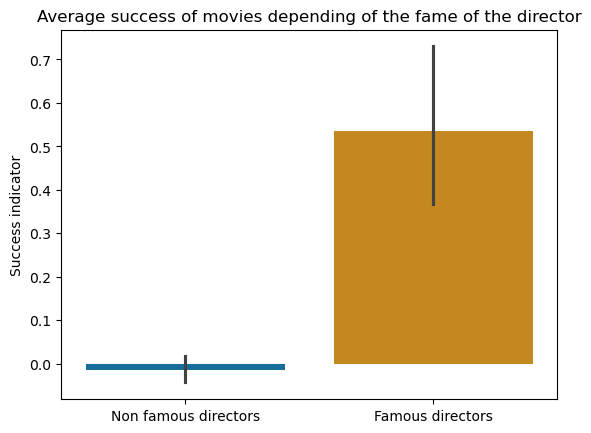

In [48]:
# Create a bar plot to visualize the relationship between the fame of the director (IsFamousDirector==1) and the success indicator of movies

success_data['IsFamousDirector'] = success_data['IsFamousDirector'].astype(int)
ax = sns.barplot(data=success_data, x='IsFamousDirector',y='Success_indicator',palette='colorblind')
ax.set(xticklabels=['Non famous directors','Famous directors'],xlabel=None,ylabel='Success indicator',title='Average success of movies depending of the fame of the director')

Again, the difference of success indicator mean between movies produce by a famous director and other movies seems obvious. We perform a t-test to confirm this.

In [49]:
#T-test
cat3 = success_data[success_data['IsFamousDirector']==0]
cat4 = success_data[success_data['IsFamousDirector']==1]

ttest_ind(cat3['Success_indicator'],cat4['Success_indicator'])

TtestResult(statistic=-6.855485250183014, pvalue=8.824410120295185e-12, df=2628.0)

The p-value is indeed inferior to 0.05. The fame of the director is then another confoundder for a movie success.

## 3.5 - Budget influence

Because the data on movies' budget was reducing too much our dataframe, we decided not to include it in the success indicator (and using the profit instead of the revenu). However, it could be intersting to look into the influence of the budget on movies' success.

In [50]:
# Create standardized budget and create csv for website
success_data['Budget_standardized']= (success_data['Budget_adjusted']-success_data['Budget_adjusted'].mean())/ success_data['Budget_adjusted'].std()
success_data.to_csv("Data/success_data.csv")

In [51]:
# Remove rows with budget of 0 (missing information)
indexNames=success_data[success_data['Budget_adjusted']==0].index
budget_analysis_data=success_data.drop(indexNames)

[Text(0.5, 0, 'Standardized budget'),
 Text(0, 0.5, 'Number of movies'),
 Text(0.5, 1.0, 'Distributon of movies budget')]

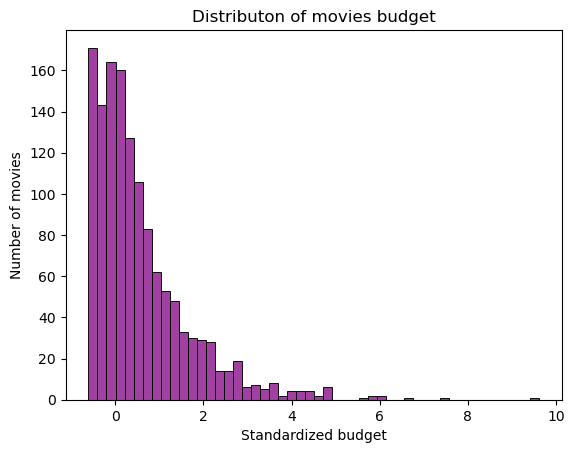

In [52]:
# Plot distribution of the budget
ax=sns.histplot(data=budget_analysis_data,x='Budget_standardized',color='purple')
ax.set(xlabel='Standardized budget',ylabel='Number of movies',title='Distributon of movies budget')


## heavy tailed distribution and log scale?? not sure
The budget of our movieset has a heavy-tailed distribution. We thus go to logscale to represent our data.

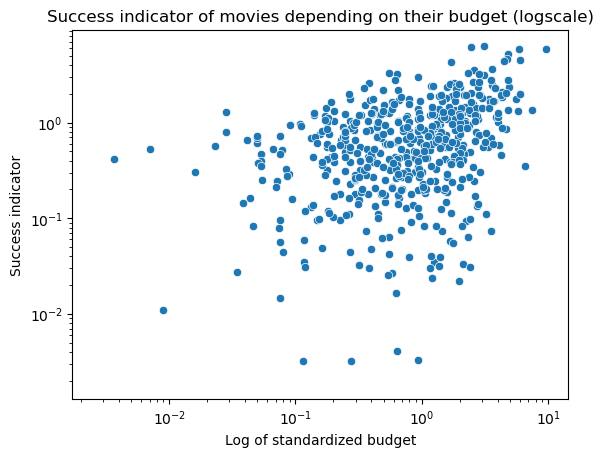

In [72]:
#Plot
ax=sns.scatterplot(data=budget_analysis_data,x='Budget_standardized',y='Success_indicator')
ax.set(xlabel='Log of standardized budget', ylabel='Success indicator', title='Success indicator of movies depending on their budget (logscale)')
plt.xscale('log')
plt.yscale('log')


## Correlation with logregression?? pb, our data are negative, not working

In [54]:
mod_2=smf.ols(formula='imdb_rating_standardized ~ Budget_standardized ', data=success_data)

res_2 = mod_2.fit()

print(res_2.summary())

                               OLS Regression Results                               
Dep. Variable:     imdb_rating_standardized   R-squared:                       0.000
Model:                                  OLS   Adj. R-squared:                 -0.000
Method:                       Least Squares   F-statistic:                    0.2684
Date:                      Fri, 15 Dec 2023   Prob (F-statistic):              0.604
Time:                              12:24:58   Log-Likelihood:                -3691.2
No. Observations:                      2630   AIC:                             7386.
Df Residuals:                          2628   BIC:                             7398.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

There is no correlation between the budget and the success indicator, meaning that we could exclude it from our potential confounders.

## 3.6 - Movie genre influence

The genre of the movie might influences its success. Let's plot the average success per genre.

/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/638967518.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=success_data, x='Movie_main_genre',y='Success_indicator',palette='colorblind')


[Text(0.5, 0, 'Main movie genres'),
 Text(0, 0.5, 'Success indicator'),
 Text(0.5, 1.0, 'Average success indicator of main movie genres')]

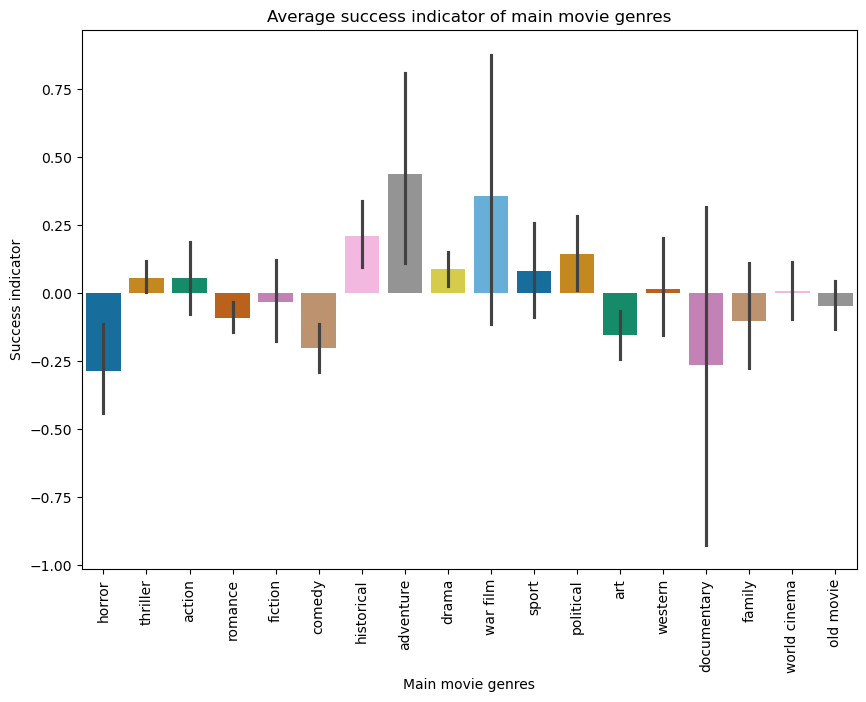

In [55]:
plt.figure(figsize=(10,7))
plt.xticks(rotation=90)
ax = sns.barplot(data=success_data, x='Movie_main_genre',y='Success_indicator',palette='colorblind')
ax.set(xlabel='Main movie genres',ylabel='Success indicator',title='Average success indicator of main movie genres')


It seems like the success indicator's mean is changing depending on the genre of the movies. Let's perfom an ANOVA statistical test (parametric or non-parametric alternative).

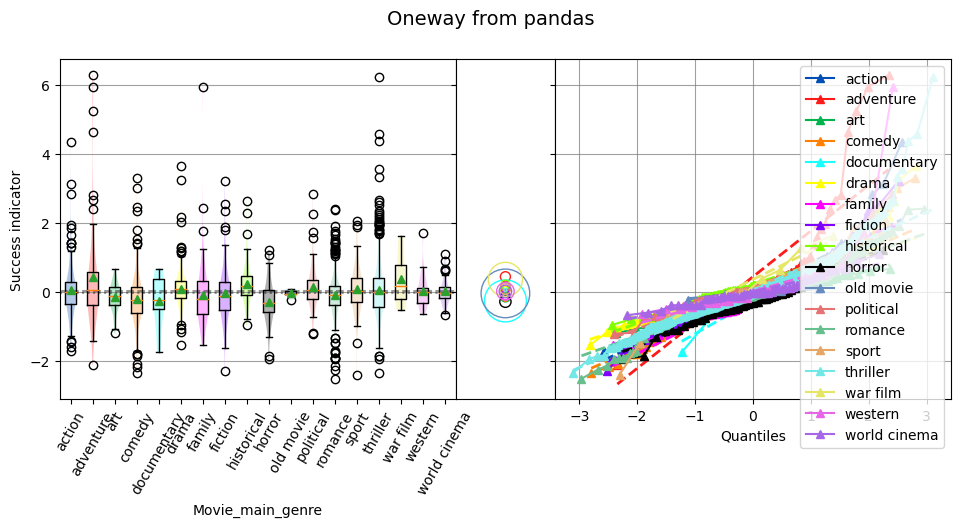



Overall Statistics
------------------

Number of Groups =  18
Total            =  2630
Grand Mean       =  0.0145
Pooled Std Dev   =  0.7403
Grand Median     = -0.0301


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
137            0.0565        0.8362       -1.7094       -0.0187        4.3415       action        
72             0.4359        1.5155       -2.1217        0.0405        6.2895       adventure     
78            -0.1551        0.3907       -1.2093       -0.1269        0.6589       art           
266           -0.2040        0.7405       -2.3667       -0.2332        3.2950       comedy        
6             -0.2659        0.8759       -1.7601       -0.2283        0.6714       documentary   
288            0.0882        0.5531       -1.5511        0.0938        3.6571       drama         
8

In [73]:
# Perform statistical analysis, ANOVA or non-parametric ANOVA (Kruslkall Wallis)
analyze(
    success_data['Success_indicator'],
    groups=success_data['Movie_main_genre'],
    categories='Movie_main_genre',
    name='Success indicator',
    title='Oneway from pandas'
)

The p-value is inferior to 0.05, and we can thus reject the null Hypothesis. The means of success indicator for different genres are not matched. The genre of the movie is another confounder for the success of a movie.

### Conclusion

These insights on potential confoudners for success of a movie reveal that a lot of factors can influence our success indicator. We thought about creating a matching dataset, but these kind of "tricks" only works for binary data (one control group and one treated group). Binarize our success indicator would be risky to provide meaningful conclusions for further analysis. Thus, we have to remain careful when analyzing further results, and keep in mind these confounders.

# Time series analysis ==> TO MOVE IN 2

### Title length through time

In [57]:
# Add a column for the title length in words
movies['Title_length'] = movies['Movie_name'].apply(count_words)

<Axes: title={'center': 'Average title length per year (confidence interval 95%)'}, xlabel='Movie release year', ylabel='Title length'>

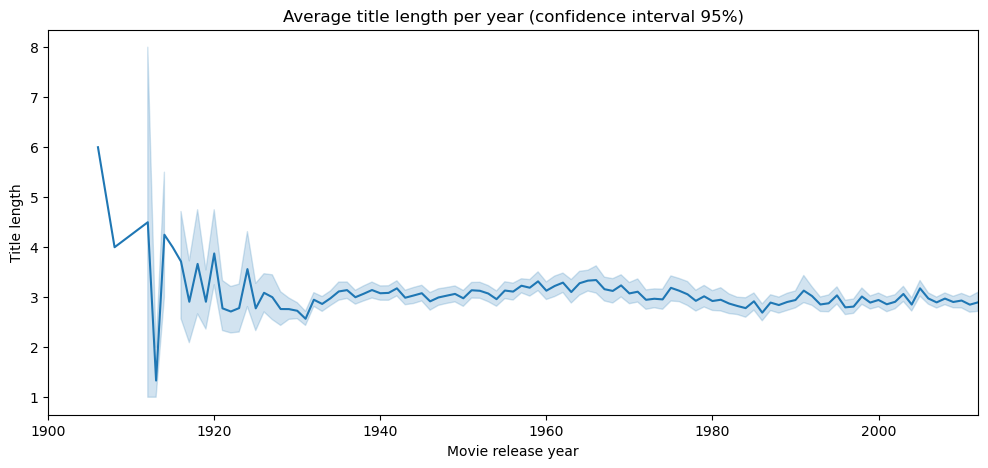

In [58]:
# Plot of the average title length per year

plt.figure(figsize=(12,5))
plt.xlim(1900,2012)
plt.xlabel('Movie release year')
plt.ylabel('Title length')
plt.title('Average title length per year (confidence interval 95%)')
sns.lineplot(x='Movie_release_date', y='Title_length', errorbar='ci', data=movies)

The title length is **scattered at the beginning of the 20th century**. The average title length is **rather stable from 1930 to 2012** (very small confidence intervals).

As very few movies were released at the beginning of the 20th century, we will plot join distributions of title length and number of movies released per year.

Text(0.5, 0.98, 'Join distributions of title length and year')

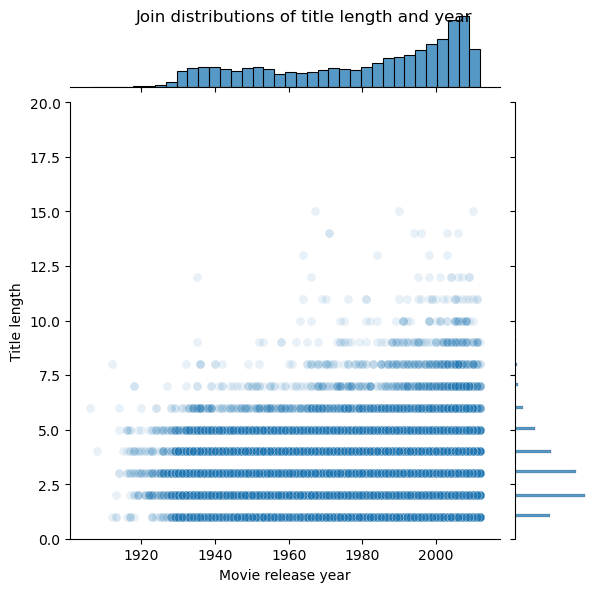

In [59]:
# Plot of the join distributions of title length and number of movies released per year, 

jplot = sns.jointplot(x='Movie_release_date', y='Title_length', data=movies, joint_kws={'s' : 40, 'alpha': 0.1})
plt.xlabel('Movie release year')
plt.ylabel('Title length')
plt.ylim(0,20)
jplot.fig.suptitle('Join distributions of title length and year')

## Genre analysis => TO MOVE IN 2

### Title length

Does each genre have a specific title length? Did it evolve through time?

This first visualization will help us to draw further analyses.

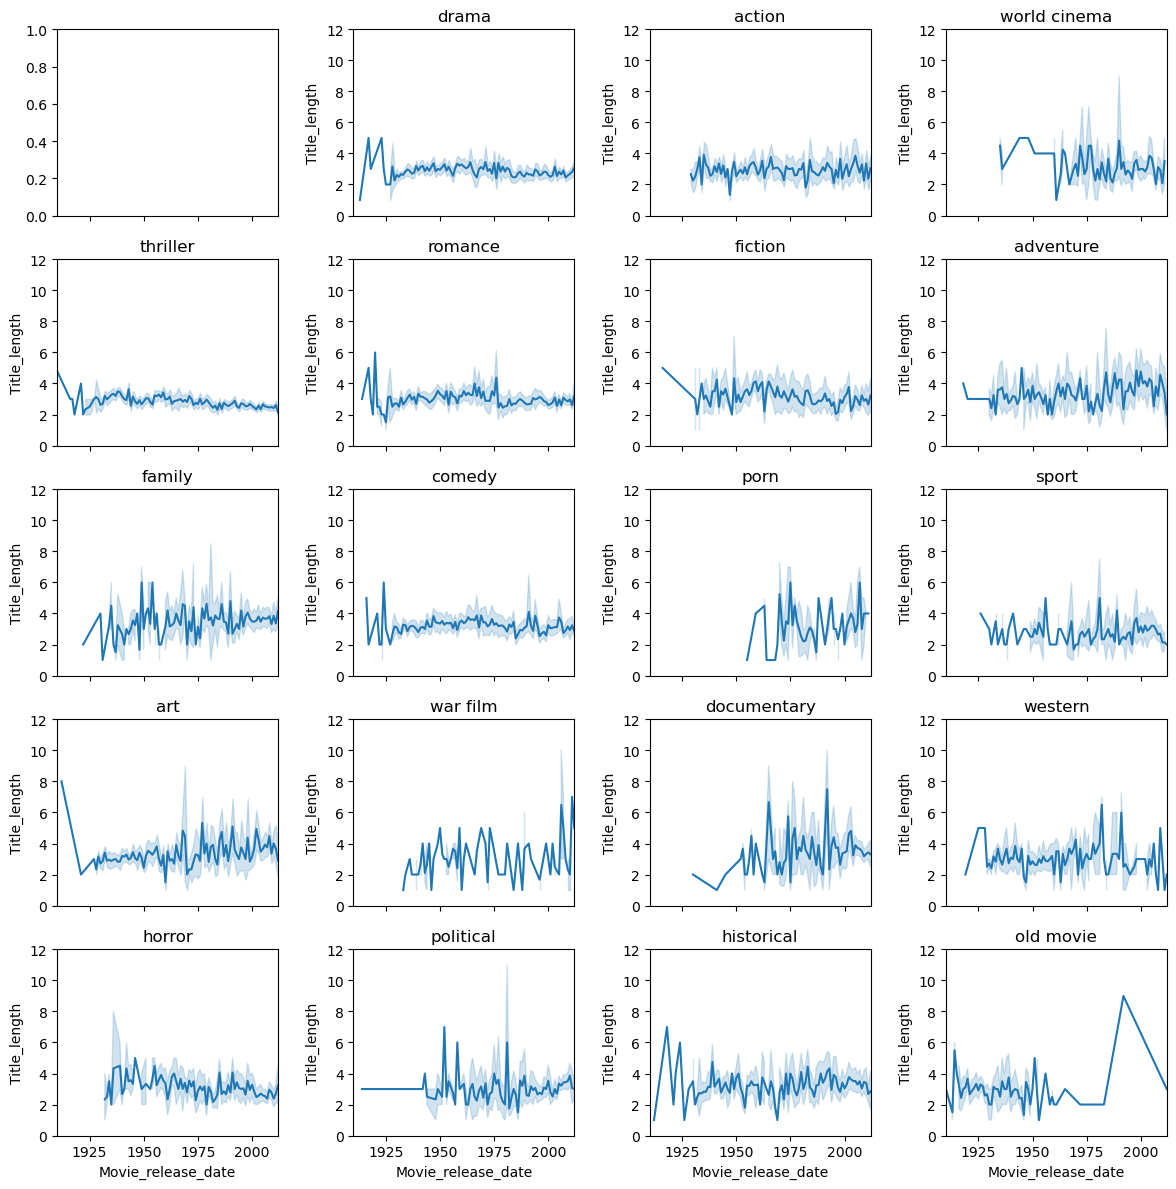

In [60]:
import math

# Create a list containing the 19 genre names 
genres = movies['Movie_main_genre'].unique()[:19]

# Plot the evolution of title length per genre with a confidence interval of 95%
nrows = 5
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12), sharex=True)

for i, genre in enumerate(genres, 1):
    # Create a temporary dataframe containing only one genre
    genre_data = movies[movies['Movie_main_genre'] == genre]
    
    # Plot in the adequate subpanel the title length per year for that genre
    sns.lineplot(x='Movie_release_date', y='Title_length', errorbar='ci', data=genre_data, ax=axes[i%5, math.floor(i/5)])
    
    axes[i%5, math.floor(i/5)].set_title(f'{genre}')
    axes[i%5, math.floor(i/5)].set_ylim(0, 12)
    axes[i%5, math.floor(i/5)].set_xlim(1910, 2012)

plt.tight_layout()
plt.show()

# 4 - Title key features influence on success

## 4.1 - Title length in characters

## 4.2 - Presence of protagonist

## 4.3 - Part-of-speech analysis : grammatical (verbs, adjective)

## 4.4 - Part-of-speech analysis : proper nouns (characters, dates, location)

## 4.5 - Sentiment analysis

We want to investigate the lexical fields and the conotation of our titles. This would provide us useful information to link with success, time, genre. We make the naive assumption that darker, scarier movies are associated with negative sentiments, whereas comedy and romance films are associated with more positive sentiments.

NLTK is a well-known and well-trained NLP library. The NLTK.ipynb notebook goes through basic functions of NLTK package that could be applied to movie's title.


#### NLTK's Sentiment Analyzer (pre-trained)

NLTK already has a built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).

Since VADER is pretrained, you can get results more quickly than with many other analyzers. However, VADER is best suited for language used in social media, like short sentences with some slang and abbreviations. It’s less accurate when rating longer, structured sentences. This point is actually very interesting for us since titles are usually short.



In [61]:
import nltk

In [62]:
#An example of polarity sentiment analysis with NLTK

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is really powerful!")

{'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.8012}

In [63]:
# Sentiment analysis depending on genre
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
L_pos=[]
L_neg=[]


for i in range(len(movie_metadata_filtered)):
    movie_name = movie_metadata_filtered.iloc[i].Movie_name
    scores = sia.polarity_scores(movie_name)
    L_pos.append(scores["pos"])
    L_neg.append(scores["neg"])


movie_metadata_filtered['pos_sentiment']=L_pos
movie_metadata_filtered['neg_sentiment']=L_neg


/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/4179263746.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(movie_metadata_filtered, x="Movie_main_genre", y="pos_sentiment",palette='colorblind')


[Text(0.5, 0, 'Main genres'),
 Text(0, 0.5, 'Positive sentiment score'),
 Text(0.5, 1.0, 'Positive sentiment per genre')]

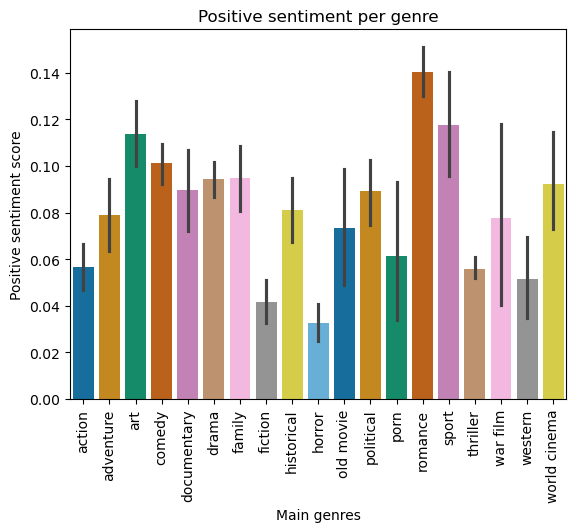

In [64]:
ax=sns.barplot(movie_metadata_filtered, x="Movie_main_genre", y="pos_sentiment",palette='colorblind')
plt.xticks(rotation=90)
ax.set(xlabel="Main genres",ylabel="Positive sentiment score",title="Positive sentiment per genre")

/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/4157152296.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(movie_metadata_filtered, x="Movie_main_genre", y="neg_sentiment",palette='colorblind')


[Text(0.5, 23.999999999999986, 'Main genres'),
 Text(24.00000000000002, 0.5, 'Negative sentiment score'),
 Text(0.5, 1.0, 'Negative sentiment per genre')]

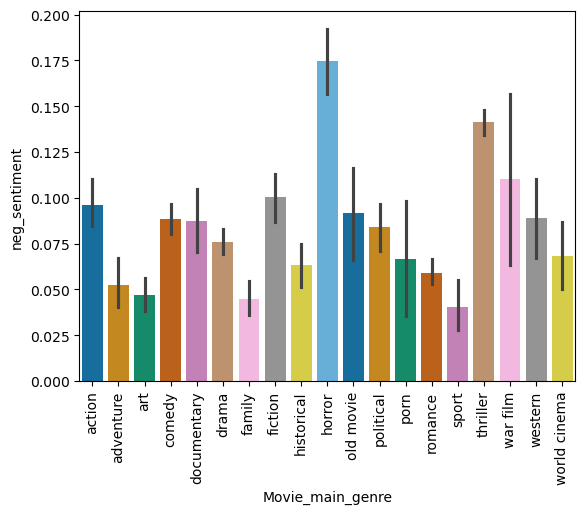

In [65]:
sns.barplot(movie_metadata_filtered, x="Movie_main_genre", y="neg_sentiment",palette='colorblind')
plt.xticks(rotation=90)
ax.set(xlabel="Main genres",ylabel="Negative sentiment score",title="Negative sentiment per genre")


The two plots confirm our naive assumption:
- Romance movie's titles are associated with higher positive sentiment score.
- Horror movie's titles are associated with higher negative sentiment score.

*To be continued*

#Topic and lexical field analysis

### First option: handmade 

The first option is to generate our own lexical fields (approximately 200 words) for each genre using AI word generator. We then calculate the frequency of words inside a lexical field associated with movies' genre.

*To be done soon*

### Second option: LDA model

For this option, we need to load our documents and put them in Unicode string format (each document is a Unicode string). We process the titles and plot summaries of each movie using the key steps presented in the NLTK.ipynb (see Sentiment_Topic_Analysis.ipynb). Then, we use the LDA model from gensim package. We train the model on the processed plot summaries. It returns lists of words associated together to a topic. For the moment, this solution does not seem to return lists that we can assign to coherent lexical fields that we could use.

*To be continued*


# 5 - Prediction

To be continued